In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content | grep npy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("[INFO] Libraries loaded successfully.")

[INFO] Libraries loaded successfully.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

LOAD_DIR = "/content/drive/MyDrive/car_damage_detection"

trainX = np.load(f"{LOAD_DIR}/trainX.npy")
trainY = np.load(f"{LOAD_DIR}/trainY.npy")
testX  = np.load(f"{LOAD_DIR}/testX.npy")
testY  = np.load(f"{LOAD_DIR}/testY.npy")

print("trainX:", trainX.shape)
print("trainY:", trainY.shape)
print("testX :", testX.shape)
print("testY :", testY.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
trainX: (1840, 224, 224, 3)
trainY: (1840, 2)
testX : (460, 224, 224, 3)
testY : (460, 2)


In [4]:
# --- Define Hyperparameters + Augmentation ---

# --- Hyperparameters ---
INIT_LR = 1e-5     # learning rate
EPOCHS = 30        # fewer epochs at first (increase later if needed)
BS = 32            # batch size

# --- Data Augmentation ---
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

print("[INFO] Data augmentation generator ready.")

[INFO] Data augmentation generator ready.


In [5]:
# --- Load base MobileNetV2 model ---
baseModel = MobileNetV2(weights="imagenet",
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

# --- Add custom classification head ---
headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# --- Combine base & head ---
model = Model(inputs=baseModel.input, outputs=headModel)

# --- Freeze base layers (train only top) ---
for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] Model created successfully.")
model.summary()

/tmp/ipython-input-806057595.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet",


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[INFO] Model created successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# --- Compile model ---
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] Model compiled.")

[INFO] Model compiled.


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [7]:
# --- Define callbacks ---
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_mobilenetv2.h5", monitor="val_accuracy", save_best_only=True)

# --- Train ---
print("[INFO] Training started...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)

print("[INFO] Training completed.")

[INFO] Training started...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4769 - loss: 2.9713

57/57 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.4772 - loss: 2.9661 - val_accuracy: 0.4804 - val_loss: 1.3925
Epoch 2/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 1:08 1s/step - accuracy: 0.4375 - loss: 3.3247

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 389ms/step - accuracy: 0.4375 - loss: 3.3247 - val_accuracy: 0.4826 - val_loss: 1.3871
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4978 - loss: 2.5497

57/57 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.4980 - loss: 2.5469 - val_accuracy: 0.5630 - val_loss: 1.0563
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 733ms/step - accuracy: 0.5625 - loss: 2.6586 - val_accuracy: 0.5630 - val_loss: 1.0523
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5531 - loss: 1.9840

57/57 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.5532 - loss: 1.9825 - val_accuracy: 0.6457 - val_loss: 0.8481
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.7812 - loss: 1.3559 - val_accuracy: 0.6457 - val_loss: 0.8459
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6102 - loss: 1.5810

57/57 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.6102 - loss: 1.5804 - val_accuracy: 0.7196 - val_loss: 0.7753
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 380ms/step - accuracy: 0.5938 - loss: 1.4255 - val_accuracy: 0.7196 - val_loss: 0.7743
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6340 - loss: 1.3212

57/57 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.6340 - loss: 1.3212 - val_accuracy: 0.7457 - val_loss: 0.6860
Epoch 10/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 377ms/step - accuracy: 0.5312 - loss: 1.4667 - val_accuracy: 0.7457 - val_loss: 0.6845
Epoch 11/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6298 - loss: 1.3052

57/57 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.6301 - loss: 1.3036 - val_accuracy: 0.7630 - val_loss: 0.6367
Epoch 12/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.6562 - loss: 1.0155 - val_accuracy: 0.7630 - val_loss: 0.6359
Epoch 13/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6729 - loss: 1.0375

57/57 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.6726 - loss: 1.0382 - val_accuracy: 0.7783 - val_loss: 0.5971
Epoch 14/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 400ms/step - accuracy: 0.5625 - loss: 1.4472 - val_accuracy: 0.7783 - val_loss: 0.5965
Epoch 15/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6893 - loss: 0.9930

57/57 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.6893 - loss: 0.9917 - val_accuracy: 0.7848 - val_loss: 0.5881
Epoch 16/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - accuracy: 0.7188 - loss: 0.8017 - val_accuracy: 0.7848 - val_loss: 0.5884
Epoch 17/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7042 - loss: 0.7924

57/57 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.7041 - loss: 0.7928 - val_accuracy: 0.7870 - val_loss: 0.5582
Epoch 18/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 402ms/step - accuracy: 0.8750 - loss: 0.4816 - val_accuracy: 0.7848 - val_loss: 0.5599
Epoch 19/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7263 - loss: 0.7522 - val_accuracy: 0.7848 - val_loss: 0.5451
Epoch 20/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 517ms/step - accuracy: 0.7188 - loss: 0.5261 - val_accuracy: 0.7848 - val_loss: 0.5454
Epoch 21/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.7270 - loss: 0.6948 - val_accuracy: 0.7848 - val_loss: 0.5302
Epoch 22/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 381ms/step - accuracy: 0.6250 - loss: 0.9278 - val_accuracy: 0.7848 - val_loss: 0.5306
Epoch 23/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.7363 - loss: 0.7003 - val_accuracy: 0.7870 - val_loss: 0.5188
Epoch 24/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 397ms/step - accuracy: 0.6562 - loss: 0.7889 - val_accuracy: 0.7870

57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 739ms/step - accuracy: 0.7500 - loss: 0.5243 - val_accuracy: 0.7891 - val_loss: 0.5038
Epoch 27/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7559 - loss: 0.6428

57/57 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7558 - loss: 0.6427 - val_accuracy: 0.7957 - val_loss: 0.4921
Epoch 28/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 422ms/step - accuracy: 0.8750 - loss: 0.3220 - val_accuracy: 0.7957 - val_loss: 0.4919
Epoch 29/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7492 - loss: 0.6511

57/57 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.7492 - loss: 0.6508 - val_accuracy: 0.7978 - val_loss: 0.4779
Epoch 30/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.7188 - loss: 0.6424 - val_accuracy: 0.7978 - val_loss: 0.4773
[INFO] Training completed.


In [8]:
from tensorflow.keras.optimizers import Adam

print("[INFO] Unfreezing some MobileNetV2 layers for fine‑tuning...")

# Unfreeze the last 20 layers of the base model
for layer in baseModel.layers[-20:]:
    layer.trainable = True

# Re‑compile with a smaller learning rate
opt_finetune = Adam(learning_rate=1e-6)

model.compile(loss="categorical_crossentropy", optimizer=opt_finetune, metrics=["accuracy"])

print("[INFO] Recompiled model with trainable base layers and lower LR.")

# class weights to emphasize damaged cars
class_weight = {0: 3.0, 1: 1.0}

# Continue training (fine‑tuning)
EPOCHS_FINETUNE = 10  # start with 5–10 extra epochs
BS = 32

print("[INFO] Starting fine‑tuning...")

H_finetune = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    epochs=EPOCHS_FINETUNE,
    class_weight=class_weight,
    callbacks=[early_stop, checkpoint]
)

print("[INFO] Fine‑tuning completed!")

# Save your improved model


[INFO] Unfreezing some MobileNetV2 layers for fine‑tuning...
[INFO] Recompiled model with trainable base layers and lower LR.
[INFO] Starting fine‑tuning...
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6179 - loss: 1.6551

57/57 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.6182 - loss: 1.6535 - val_accuracy: 0.8087 - val_loss: 0.4687
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.7188 - loss: 0.9464 - val_accuracy: 0.8087 - val_loss: 0.4685
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6879 - loss: 1.2622

57/57 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.6874 - loss: 1.2634 - val_accuracy: 0.8174 - val_loss: 0.4595
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 367ms/step - accuracy: 0.5625 - loss: 1.9777 - val_accuracy: 0.8174 - val_loss: 0.4594
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6603 - loss: 1.4322

57/57 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.6604 - loss: 1.4325 - val_accuracy: 0.8261 - val_loss: 0.4468
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.6875 - loss: 0.6110 - val_accuracy: 0.8261 - val_loss: 0.4464
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6582 - loss: 1.5430

57/57 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.6584 - loss: 1.5406 - val_accuracy: 0.8304 - val_loss: 0.4339
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.6562 - loss: 1.3102 - val_accuracy: 0.8304 - val_loss: 0.4338
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.6498 - loss: 1.3636 - val_accuracy: 0.8304 - val_loss: 0.4304
Epoch 10/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 387ms/step - accuracy: 0.7812 - loss: 0.7174 - val_accuracy: 0.8304 - val_loss: 0.4302
[INFO] Fine‑tuning completed!


In [9]:
model.save("/content/drive/MyDrive/car_damage_detection/MobileNet_Car_detection_FineTuned.keras")
print("[INFO] Fine‑tuned model saved as MobileNet_Car_detection_FineTuned.keras")

[INFO] Fine‑tuned model saved as MobileNet_Car_detection_FineTuned.keras


[INFO] Evaluating model...
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
              precision    recall  f1-score   support

   00-damage       0.90      0.75      0.82       230
    01-whole       0.78      0.91      0.84       230

    accuracy                           0.83       460
   macro avg       0.84      0.83      0.83       460
weighted avg       0.84      0.83      0.83       460



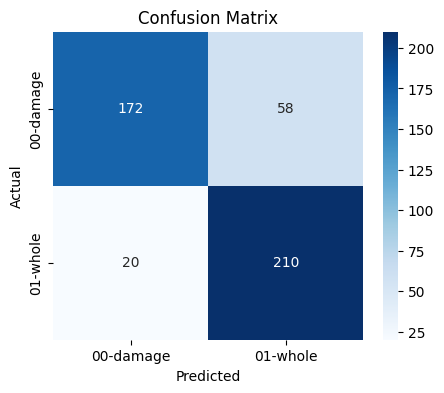

In [10]:
# --- Evaluate model ---
print("[INFO] Evaluating model...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
trueIdxs = np.argmax(testY, axis=1)

# --- Classification report ---
print(classification_report(trueIdxs, predIdxs, target_names=["00-damage", "01-whole"]))

# --- Confusion matrix ---
cm = confusion_matrix(trueIdxs, predIdxs)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["00-damage","01-whole"],
            yticklabels=["00-damage","01-whole"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

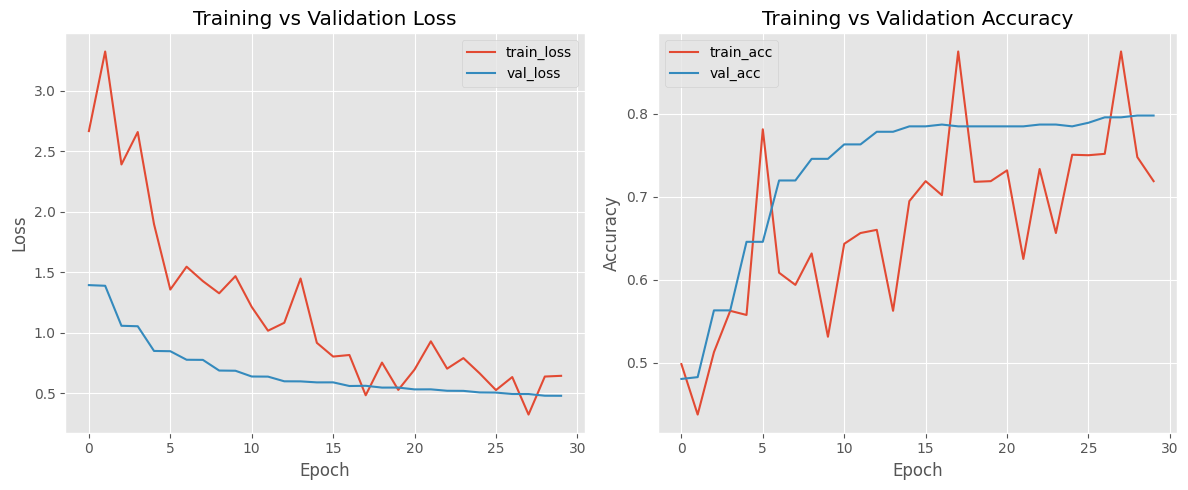

In [11]:
# --- Plot accuracy/loss curves ---
N = len(H.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# --- Save trained model ---
model.save("MobileNet_Car_detection_Final.h5")
print("[INFO] Model saved as MobileNet_Car_detection_Final.h5")

[INFO] Model saved as MobileNet_Car_detection_Final.h5


In [13]:
model.save("/content/drive/MyDrive/car_damage_detection/MobileNet_Car_detection_Final.keras")